<a href="https://colab.research.google.com/github/ensarakbas77/Match-Result-Prediction/blob/main/PatchTST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import warnings
import time
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [ ]:
file_path= 'Matches.xlsx'
df=pd.read_excel(file_path)

# Sadece geçerli sonuçları tut
df = df[df['Sonuç'].isin([-1, 0, 1])]

# Haritalama işlemi
sonuc_mapping = {-1: 0, 0: 1, 1: 2}
df['Sonuç'] = df['Sonuç'].map(sonuc_mapping)

# **SEKANS VE STATİK ÖZELLİKLER**

In [ ]:
# Takıma ve tarihe göre sırala
df = df.sort_values(by=['Takım ID', 'Tarih'])

# Boş değeri doldur
df["Şut Verimliliği"] = df["Şut Verimliliği"].fillna(df["Şut Verimliliği"].mean())

# Feature listeleri
sequence_features = [
    'Gol', 'Rakip Gol', 'Topla Oynama(%)', 'Şut', 'İsabetli Şut', 'Başarılı Pas',
    'Pas Başarısı(%)', 'Korner', 'Orta', 'Faul', 'Ofsayt',
    'Rakip Topla Oynama(%)', 'Rakip Şut', 'Rakip İsabetli Şut', 'Rakip Başarılı Pas',
    'Rakip Pas Başarısı(%)', 'Rakip Korner', 'Rakip Orta', 'Rakip Faul', 'Rakip Ofsayt'
]

static_features = [
    'Takım ID', 'Rakip Takım ID', 'Is_Home', 'Sezon', 'Ay', 'Haftanın Günü',
    'Şut Verimliliği', 'Son 5 Maç Gol Ort', 'Son 5 Maç Galibiyet Oranı'
]


feature_means = df[sequence_features].mean().values

def pad_sequence(seq, K, mean_vec):
    if len(seq) < K:
        padding = np.tile(mean_vec, (K - len(seq), 1))
        return np.vstack([padding, seq])
    return seq


K = 10
X_seq = []
X_static = []
y = []

for idx, row in df.iterrows():
    takim_id = row['Takım ID']
    rakip_id = row['Rakip Takım ID']
    tarih = row['Tarih']

    takim_gecmis = df[(df['Takım ID'] == takim_id) & (df['Tarih'] < tarih)].sort_values(by='Tarih').tail(K)

    rakip_gecmis = df[(df['Takım ID'] == rakip_id) & (df['Tarih'] < tarih)].sort_values(by='Tarih').tail(K)

    #if len(takim_gecmis) < 1 or len(rakip_gecmis) < 1:
        #continue

    takim_seq = pad_sequence(takim_gecmis[sequence_features].values, K, feature_means)
    rakip_seq = pad_sequence(rakip_gecmis[sequence_features].values, K, feature_means)

    full_seq = np.vstack([takim_seq, rakip_seq])

    static_vec = row[static_features].values.astype(np.float32)
    label = row['Sonuç']

    X_seq.append(full_seq)
    X_static.append(static_vec)
    y.append(label)


In [ ]:
X_seq = np.array(X_seq, dtype=np.float32)
X_static = np.array(X_static, dtype=np.float32)
y = np.array(y, dtype=np.int64)

print("X_seq shape     :", X_seq.shape)
print("X_static shape  :", X_static.shape)
print("y shape         :", y.shape)
print("Sınıf dağılımı  :", Counter(y))


X_seq shape     : (3734, 20, 20)
X_static shape  : (3734, 9)
y shape         : (3734,)
Sınıf dağılımı  : Counter({np.int64(2): 2241, np.int64(0): 788, np.int64(1): 705})


# **Küme Ayrımı**

In [ ]:
val_ratio = 0.15
test_ratio = 0.15

total_samples = len(X_seq)
test_size = int(total_samples * test_ratio)
val_size = int(total_samples * val_ratio)
train_size = total_samples - val_size - test_size

X_seq_train = X_seq[:train_size]
X_static_train = X_static[:train_size]
y_train = y[:train_size]

X_seq_val = X_seq[train_size:train_size + val_size]
X_static_val = X_static[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

X_seq_test = X_seq[-test_size:]
X_static_test = X_static[-test_size:]
y_test = y[-test_size:]


print("Train:", len(y_train), "Val:", len(y_val), "Test:", len(y_test))
print("Train Sınıf Dağılımı:", Counter(y_train))
print("Val   Sınıf Dağılımı:", Counter(y_val))
print("Test  Sınıf Dağılımı:", Counter(y_test))


Train: 2614 Val: 560 Test: 560
Train Sınıf Dağılımı: Counter({np.int64(2): 1604, np.int64(0): 512, np.int64(1): 498})
Val   Sınıf Dağılımı: Counter({np.int64(2): 338, np.int64(0): 121, np.int64(1): 101})
Test  Sınıf Dağılımı: Counter({np.int64(2): 299, np.int64(0): 155, np.int64(1): 106})


# **Encoding + Ölçekleme**

In [ ]:
# 1. Tüm setleri DataFrame'e çevir
df_static_train = pd.DataFrame(X_static_train, columns=static_features)
df_static_val   = pd.DataFrame(X_static_val,   columns=static_features)
df_static_test  = pd.DataFrame(X_static_test,  columns=static_features)

# 2. Takım ve Rakip ID'leri ayır
takim_ids_train = df_static_train["Takım ID"].values.astype(np.int64)
rakip_ids_train = df_static_train["Rakip Takım ID"].values.astype(np.int64)

takim_ids_val = df_static_val["Takım ID"].values.astype(np.int64)
rakip_ids_val = df_static_val["Rakip Takım ID"].values.astype(np.int64)

takim_ids_test = df_static_test["Takım ID"].values.astype(np.int64)
rakip_ids_test = df_static_test["Rakip Takım ID"].values.astype(np.int64)

# 3. Encoding yapılacak sütunlar
categorical_ohe_cols = ['Sezon', 'Ay', 'Haftanın Günü']
numerical_cols = ['Is_Home', 'Şut Verimliliği', 'Son 5 Maç Gol Ort', 'Son 5 Maç Galibiyet Oranı']

# 4. One-Hot Encoder
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ohe.fit(df_static_train[categorical_ohe_cols])

# 5. Encode edilmiş kategorik özellikler
ohe_train = ohe.transform(df_static_train[categorical_ohe_cols])
ohe_val   = ohe.transform(df_static_val[categorical_ohe_cols])
ohe_test  = ohe.transform(df_static_test[categorical_ohe_cols])

# 6. Numerik özellikler için StandardScaler
scaler = StandardScaler()
scaler.fit(df_static_train[numerical_cols])

scaled_train = scaler.transform(df_static_train[numerical_cols])
scaled_val   = scaler.transform(df_static_val[numerical_cols])
scaled_test  = scaler.transform(df_static_test[numerical_cols])

# 7. Final encode edilmiş
X_static_train_encoded = np.hstack([ohe_train, scaled_train]).astype(np.float32)
X_static_val_encoded   = np.hstack([ohe_val, scaled_val]).astype(np.float32)
X_static_test_encoded  = np.hstack([ohe_test, scaled_test]).astype(np.float32)


# X_seq: (N, T=20, F=20)
N_train = X_seq_train.shape[0]
N_val   = X_seq_val.shape[0]
N_test  = X_seq_test.shape[0]
seq_len = X_seq_train.shape[1]
F       = X_seq_train.shape[2]

scaler_seq = StandardScaler()

# --- Train: fit + transform ---
X_seq_train_flat = X_seq_train.reshape(-1, F)
X_seq_train_scaled_flat = scaler_seq.fit_transform(X_seq_train_flat)
X_seq_train_scaled = X_seq_train_scaled_flat.reshape(N_train, seq_len, F)

# --- Val: transform only ---
X_seq_val_flat = X_seq_val.reshape(-1, F)
X_seq_val_scaled_flat = scaler_seq.transform(X_seq_val_flat)
X_seq_val_scaled = X_seq_val_scaled_flat.reshape(N_val, seq_len, F)

# --- Test: transform only ---
X_seq_test_flat = X_seq_test.reshape(-1, F)
X_seq_test_scaled_flat = scaler_seq.transform(X_seq_test_flat)
X_seq_test_scaled = X_seq_test_scaled_flat.reshape(N_test, seq_len, F)


In [ ]:
X_static_train = X_static_train_encoded
X_static_val   = X_static_val_encoded
X_static_test  = X_static_test_encoded

X_seq_train = X_seq_train_scaled
X_seq_val   = X_seq_val_scaled
X_seq_test  = X_seq_test_scaled

# 8. Kontrol
print("X_static_train:", X_static_train.shape)
print("X_static_val  :", X_static_val.shape)
print("X_static_test :", X_static_test.shape)
print()
print("takim_ids_train:", takim_ids_train.shape)
print("takim_ids_test", takim_ids_test.shape)
print("takim_ids_val", takim_ids_val.shape)
print()
print("rakip_ids_train:", rakip_ids_train.shape)
print("rakip_ids_test", rakip_ids_test.shape)
print("rakip_ids_val", rakip_ids_val.shape)
print()
print("X_seq_train:", X_seq_train.shape)
print("X_seq_val  :", X_seq_val.shape)
print("X_seq_test :", X_seq_test.shape)

X_static_train: (2614, 36)
X_static_val  : (560, 36)
X_static_test : (560, 36)

takim_ids_train: (2614,)
takim_ids_test (560,)
takim_ids_val (560,)

rakip_ids_train: (2614,)
rakip_ids_test (560,)
rakip_ids_val (560,)

X_seq_train: (2614, 20, 20)
X_seq_val  : (560, 20, 20)
X_seq_test : (560, 20, 20)


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# Tüm ID'leri birleştir
all_ids = np.concatenate([takim_ids_train, takim_ids_val, takim_ids_test,
                          rakip_ids_train, rakip_ids_val, rakip_ids_test])

# Fit işlemi tüm ID'lere yapılmalı
le.fit(all_ids)

# Encode işlemi (dönüştürme)
takim_ids_train_enc = le.transform(takim_ids_train)
rakip_ids_train_enc = le.transform(rakip_ids_train)

takim_ids_val_enc = le.transform(takim_ids_val)
rakip_ids_val_enc = le.transform(rakip_ids_val)

takim_ids_test_enc = le.transform(takim_ids_test)
rakip_ids_test_enc = le.transform(rakip_ids_test)

# Yeni vocab size
team_vocab_size = len(le.classes_)


# **MODEL**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Tensöre çevirme
def to_tensor(x, dtype=torch.float32):
    return torch.tensor(x, dtype=dtype)

# Tüm takım ID'lerini birleştir
all_team_ids = np.concatenate([takim_ids_train, takim_ids_val, takim_ids_test])

# LabelEncoder oluştur ve tüm ID'leri fit et
team_encoder = LabelEncoder()
team_encoder.fit(all_team_ids)

# Takım ID'lerini encode et
takim_ids_train_enc = team_encoder.transform(takim_ids_train)
takim_ids_val_enc = team_encoder.transform(takim_ids_val)
takim_ids_test_enc = team_encoder.transform(takim_ids_test)

# Eğitim Tensor
x_seq_train_tensor     = to_tensor(X_seq_train)
x_static_train_tensor  = to_tensor(X_static_train)
takim_ids_train_tensor = torch.tensor(takim_ids_train_enc, dtype=torch.long)
rakip_ids_train_tensor = torch.tensor(rakip_ids_train_enc, dtype=torch.long)
y_train_tensor         = torch.tensor(y_train, dtype=torch.long)

# Validation
x_seq_val_tensor     = to_tensor(X_seq_val)
x_static_val_tensor  = to_tensor(X_static_val)
takim_ids_val_tensor = torch.tensor(takim_ids_val_enc, dtype=torch.long)
rakip_ids_val_tensor = torch.tensor(rakip_ids_val_enc, dtype=torch.long)
y_val_tensor         = torch.tensor(y_val, dtype=torch.long)

# Test
x_seq_test_tensor     = to_tensor(X_seq_test)
x_static_test_tensor  = to_tensor(X_static_test)
takim_ids_test_tensor = torch.tensor(takim_ids_test_enc, dtype=torch.long)
rakip_ids_test_tensor = torch.tensor(rakip_ids_test_enc, dtype=torch.long)
y_test_tensor         = torch.tensor(y_test, dtype=torch.long)


# 1. Tüm takım ID'lerini birleştir
all_team_ids = np.concatenate([
    takim_ids_train, takim_ids_val, takim_ids_test,
    rakip_ids_train, rakip_ids_val, rakip_ids_test
])

# 2. LabelEncoder oluştur ve tüm ID'leri fit et
team_encoder = LabelEncoder()
team_encoder.fit(all_team_ids)

# 3. Takım ve rakip ID'lerini aynı encoder ile transform et
takim_ids_train_enc = team_encoder.transform(takim_ids_train)
rakip_ids_train_enc = team_encoder.transform(rakip_ids_train)

takim_ids_val_enc = team_encoder.transform(takim_ids_val)
rakip_ids_val_enc = team_encoder.transform(rakip_ids_val)

takim_ids_test_enc = team_encoder.transform(takim_ids_test)
rakip_ids_test_enc = team_encoder.transform(rakip_ids_test)

# 4. TensorDataset'leri güncelle
train_dataset = TensorDataset(
    x_seq_train_tensor,
    x_static_train_tensor,
    torch.tensor(takim_ids_train_enc, dtype=torch.long),
    torch.tensor(rakip_ids_train_enc, dtype=torch.long),
    y_train_tensor
)

val_dataset = TensorDataset(
    x_seq_val_tensor,
    x_static_val_tensor,
    torch.tensor(takim_ids_val_enc, dtype=torch.long),
    torch.tensor(rakip_ids_val_enc, dtype=torch.long),
    y_val_tensor
)

test_dataset = TensorDataset(
    x_seq_test_tensor,
    x_static_test_tensor,
    torch.tensor(takim_ids_test_enc, dtype=torch.long),
    torch.tensor(rakip_ids_test_enc, dtype=torch.long),
    y_test_tensor
)

# 5. Model parametrelerini güncelle
num_teams = len(team_encoder.classes_)
print(f"Toplam benzersiz takım sayısı: {num_teams}")
print(f"Encoded Takım ID Aralığı: 0 - {num_teams-1}")

# Kontrol: ID'lerin embedding boyutunu aşmadığından emin ol
assert takim_ids_train_enc.max() < num_teams
assert rakip_ids_train_enc.max() < num_teams
assert takim_ids_val_enc.max() < num_teams
assert rakip_ids_val_enc.max() < num_teams
assert takim_ids_test_enc.max() < num_teams
assert rakip_ids_test_enc.max() < num_teams

Toplam benzersiz takım sayısı: 294
Encoded Takım ID Aralığı: 0 - 293


In [ ]:
def create_patches(x, patch_len, stride):

    batch_size, seq_len, n_vars = x.shape

    x = x.permute(0, 2, 1)

    patches = x.unfold(dimension=-1, size=patch_len, step=stride)

    patches = patches.contiguous()

    patches = patches.view(batch_size * n_vars, patches.size(2), patches.size(3))
    return patches

class PatchTSTModel(nn.Module):
    def __init__(self, seq_len, n_vars, patch_len, stride, d_model, nhead, num_layers, static_dim, num_teams, num_classes):
        super().__init__()

        self.patch_len = patch_len
        self.stride = stride
        self.num_patches = (seq_len - patch_len) // stride + 1


        self.patch_embed = nn.Linear(patch_len, d_model)
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches, d_model))


        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, batch_first=True, dropout=0.5
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)


        self.team_embed = nn.Embedding(num_teams, 16)


        self.static_proj = nn.Sequential(
            nn.Linear(static_dim, 64),
            nn.ReLU()
        )
        self.cross_var_attn = nn.MultiheadAttention(embed_dim=64, num_heads=4)

        self.classifier = nn.Sequential(
            nn.Linear(d_model + 64 + 16*2, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes))

    def forward(self, x_seq, x_static, takim_ids, rakip_ids):

        patches = create_patches(x_seq, self.patch_len, self.stride)

        patches = self.patch_embed(patches)

        patches += self.pos_embed
        out = self.transformer(patches)

        out = out.mean(dim=1)
        out = out.view(x_seq.size(0), -1, out.size(-1))
        out = out.mean(dim=1)

        takim_emb = self.team_embed(takim_ids)
        rakip_emb = self.team_embed(rakip_ids)
        static_out = self.static_proj(x_static)
        combined = torch.cat([out, static_out, takim_emb, rakip_emb], dim=1)
        return self.classifier(combined)

In [ ]:
model = PatchTSTModel(
    seq_len=20,
    n_vars=20,
    patch_len=2,
    stride=2,
    d_model=64,
    nhead=4,
    num_layers=2,
    static_dim=X_static_train.shape[1],
    num_teams=num_teams,
    num_classes=3
).to(device)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30:
  Train Loss: 0.4033 | Val Loss: 0.3904
Epoch 2/30:
  Train Loss: 0.3778 | Val Loss: 0.3702
Epoch 3/30:
  Train Loss: 0.3577 | Val Loss: 0.3542
Epoch 4/30:
  Train Loss: 0.3488 | Val Loss: 0.3507
Epoch 5/30:
  Train Loss: 0.3414 | Val Loss: 0.3493
Epoch 6/30:
  Train Loss: 0.3365 | Val Loss: 0.3469
Epoch 7/30:
  Train Loss: 0.3316 | Val Loss: 0.3482
Epoch 8/30:
  Train Loss: 0.3267 | Val Loss: 0.3480
Epoch 9/30:
  Train Loss: 0.3241 | Val Loss: 0.3490
Epoch 10/30:
  Train Loss: 0.3206 | Val Loss: 0.3472
Epoch 11/30:
  Train Loss: 0.3162 | Val Loss: 0.3494
Epoch 12/30:
  Train Loss: 0.3152 | Val Loss: 0.3515
Epoch 13/30:
  Train Loss: 0.3100 | Val Loss: 0.3510
Epoch 14/30:
  Train Loss: 0.3127 | Val Loss: 0.3501
Epoch 15/30:
  Train Loss: 0.3067 | Val Loss: 0.3494
Early stopping triggered after 16 epochs.
Toplam eğitim süresi: 1918.21 saniye


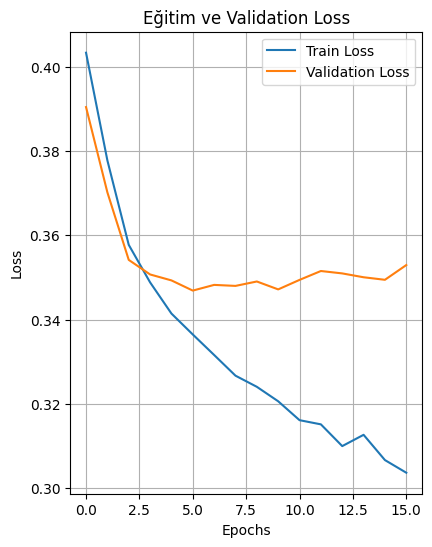

<All keys matched successfully>

In [ ]:
import torch.nn.functional as F

warnings.filterwarnings("ignore", category=UserWarning, message="The epoch parameter in `scheduler.step()`")

# Focal Loss tanımı
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.5, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            focal_loss = alpha_t * focal_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        return focal_loss

# Sınıf ağırlıkları
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = FocalLoss(alpha=class_weights, gamma=2.5).to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-3)

# Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=True
)

# DataLoader'lar
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2, pin_memory=True)

# Eğitim döngüsü ve erken durdurma
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience = 10
no_improve_count = 0
min_delta = 0.001

epochs=60

# Eğitim süresi ölçümü
total_train_start = time.time()


for epoch in range(epochs):
    # Training
    model.train()
    train_epoch_loss = 0

    for x_seq, x_static, takim, rakip, labels in train_loader:

        x_seq = x_seq.to(device, non_blocking=True)
        x_static = x_static.to(device, non_blocking=True)
        takim = takim.to(device, non_blocking=True)
        rakip = rakip.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(x_seq, x_static, takim, rakip)

        loss = criterion(outputs, labels)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        train_epoch_loss += loss.item() * labels.size(0)

    # Validation
    model.eval()
    val_epoch_loss = 0
    with torch.no_grad():
        for x_seq, x_static, takim, rakip, labels in val_loader:

            x_seq = x_seq.to(device, non_blocking=True)
            x_static = x_static.to(device, non_blocking=True)
            takim = takim.to(device, non_blocking=True)
            rakip = rakip.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            outputs = model(x_seq, x_static, takim, rakip)
            loss = criterion(outputs, labels)
            val_epoch_loss += loss.item() * labels.size(0)

    # Loss ortalamaları
    train_epoch_loss /= len(train_loader.dataset)
    val_epoch_loss /= len(val_loader.dataset)
    train_losses.append(train_epoch_loss)
    val_losses.append(val_epoch_loss)

    # Scheduler update
    scheduler.step(val_epoch_loss)

    # Erken durdurma kontrolü
    if val_epoch_loss < (best_val_loss - min_delta):
        best_val_loss = val_epoch_loss
        torch.save(model.state_dict(), 'best_patchtst.pth')
        no_improve_count = 0
        # print(f"Val loss improved to {val_epoch_loss:.4f}. Model saved.")
    else:
        no_improve_count += 1
        # print(f"No improvement in val loss for {no_improve_count}/{patience} epochs.")

        # Patience aşıldıysa eğitimi durdur
        if no_improve_count >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

    print(f"Epoch {epoch+1}/30:")
    print(f"  Train Loss: {train_epoch_loss:.4f} | Val Loss: {val_epoch_loss:.4f}")

total_train_time = time.time() - total_train_start
print(f"Toplam eğitim süresi: {total_train_time:.2f} saniye")

# Loss grafiği
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Eğitim ve Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_curve.png', dpi=300)
plt.show()

# En iyi modeli yükle
model.load_state_dict(torch.load('best_patchtst.pth'))
# print("Eğitim tamamlandı. En iyi model yüklendi.")

Çıkarım süresi: 5.42 saniye
Test Loss: 0.3763 | Accuracy: 52.68%

              precision    recall  f1-score   support

  Mağlubiyet       0.45      0.59      0.51       155
  Beraberlik       0.26      0.35      0.30       106
   Galibiyet       0.78      0.56      0.65       299

    accuracy                           0.53       560
   macro avg       0.50      0.50      0.49       560
weighted avg       0.59      0.53      0.54       560



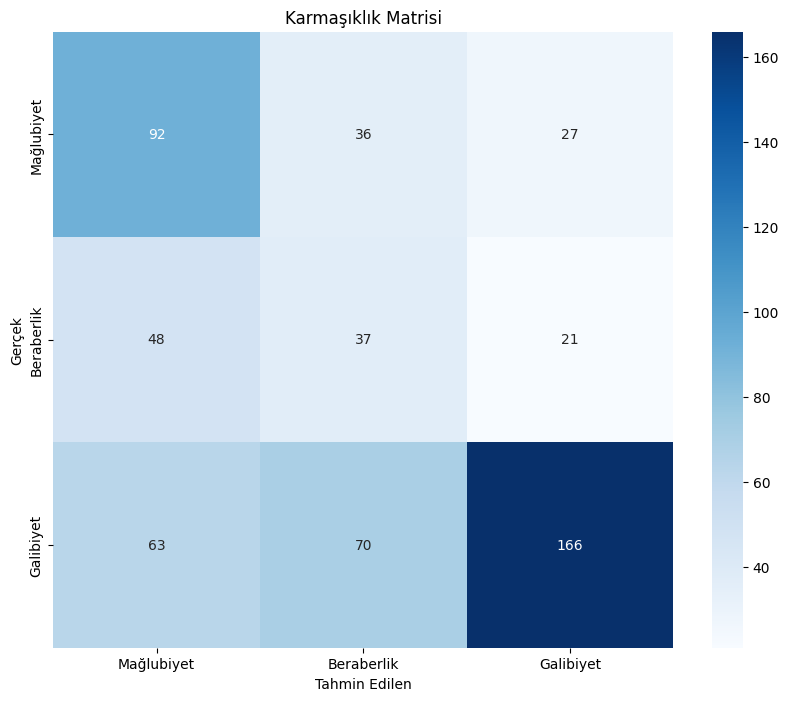

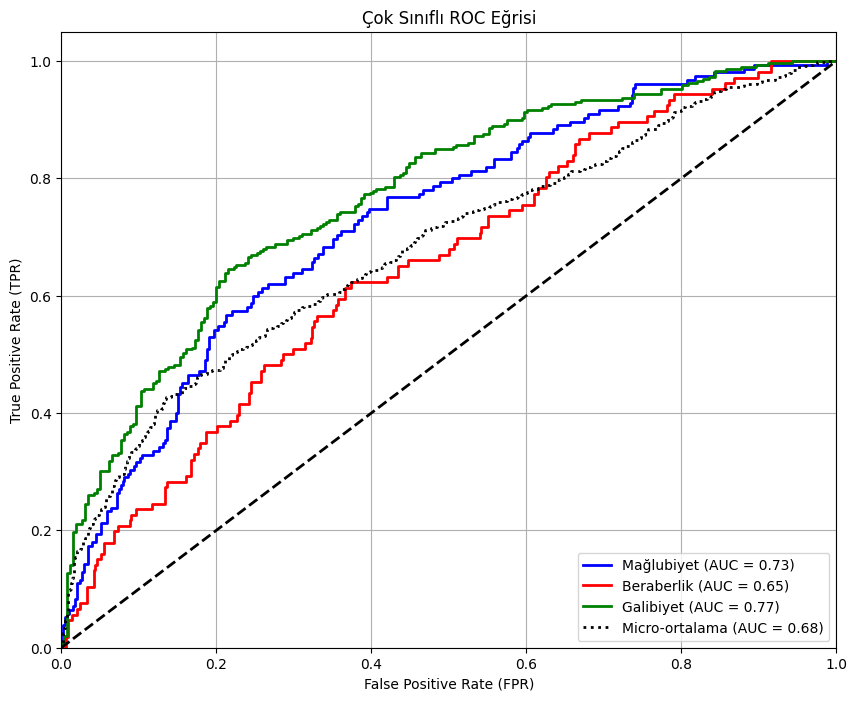

In [ ]:
# En iyi modeli yükle
model.load_state_dict(torch.load('best_patchtst.pth'))
model.eval()

# Test seti üzerinde değerlendirme
test_loss = 0
correct = 0
total = 0

start_time=time.time()

# ROC eğrileri için gerekli değişkenler
all_probs = []
all_labels = []
all_preds = []

with torch.no_grad():
    for x_seq, x_static, takim, rakip, labels in test_loader:
        x_seq, x_static = x_seq.to(device), x_static.to(device)
        takim, rakip = takim.to(device), rakip.to(device)
        labels = labels.to(device)

        outputs = model(x_seq, x_static, takim, rakip)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * labels.size(0)

        # Sınıf olasılıklarını hesapla
        probs = F.softmax(outputs, dim=1)
        _, predicted = outputs.max(1)

        # Değerleri topla
        all_probs.append(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()


finish_time=time.time()
print(f"Çıkarım süresi: {finish_time-start_time:.2f} saniye")

# Performans metriklerini hesapla
test_loss /= len(test_loader.dataset)
accuracy = 100. * correct / total

print(f"Test Loss: {test_loss:.4f} | Accuracy: {accuracy:.2f}%")
print()

# Sınıf bazlı performans
print(classification_report(all_labels, all_preds, target_names=['Mağlubiyet', 'Beraberlik', 'Galibiyet']))

# 1. Karmaşıklık Matrisi
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Mağlubiyet', 'Beraberlik', 'Galibiyet'],
            yticklabels=['Mağlubiyet', 'Beraberlik', 'Galibiyet'])
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Karmaşıklık Matrisi')
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. ROC Eğrileri (Çok Sınıflı)
# Olasılıkları birleştir
all_probs = np.vstack(all_probs)

# Etiketleri binarize et (one-vs-rest için)
binarized_labels = label_binarize(all_labels, classes=[0, 1, 2])
n_classes = binarized_labels.shape[1]

# ROC hesaplamaları
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(binarized_labels[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Mikro ortalama ROC
fpr["micro"], tpr["micro"], _ = roc_curve(binarized_labels.ravel(), all_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# ROC eğrilerini çiz
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'black']
class_names = ['Mağlubiyet', 'Beraberlik', 'Galibiyet']

# Her sınıf için ROC
for i, color, class_name in zip(range(n_classes), colors, class_names):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{class_name} (AUC = {roc_auc[i]:.2f})')

# Mikro ortalama ROC
plt.plot(fpr["micro"], tpr["micro"], color='black', linestyle=':', lw=2,
         label=f'Micro-ortalama (AUC = {roc_auc["micro"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Çok Sınıflı ROC Eğrisi')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()



In [ ]:
# 1. Karmaşıklık matrisini hesapla
cm = confusion_matrix(all_labels, all_preds)

# 2. Her sınıf için sensitivity ve specificity hesapla
sensitivity_list = []
specificity_list = []
class_names = ['Mağlubiyet', 'Beraberlik', 'Galibiyet']

#print("Karmaşıklık Matrisi:")
#print(cm)
print("\nSınıf Bazında Performans:")

for i, class_name in enumerate(class_names):
    # True Positive (TP): Doğru tahmin edilen bu sınıf örnekleri
    TP = cm[i, i]

    # False Negative (FN): Bu sınıf olması gerekirken başka tahmin edilenler
    FN = np.sum(cm[i, :]) - TP

    # False Positive (FP): Bu sınıf tahmin edildi ama aslında başka sınıfta olanlar
    FP = np.sum(cm[:, i]) - TP

    # True Negative (TN): Bu sınıf olmayan ve doğru tahmin edilmeyenler
    TN = np.sum(cm) - (TP + FP + FN)

    # Sensitivity (Recall) = TP / (TP + FN)
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0

    # Specificity = TN / (TN + FP)
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

    sensitivity_list.append(sensitivity)
    specificity_list.append(specificity)

    print(f"\n{class_name} Sınıfı:")
    #print(f"  TP: {TP}, FN: {FN}, FP: {FP}, TN: {TN}")
    print(f"  Sensitivity (Recall): {sensitivity:.4f}")
    print(f"  Specificity: {specificity:.4f}")




Sınıf Bazında Performans:

Mağlubiyet Sınıfı:
  Sensitivity (Recall): 0.5935
  Specificity: 0.7259

Beraberlik Sınıfı:
  Sensitivity (Recall): 0.3491
  Specificity: 0.7665

Galibiyet Sınıfı:
  Sensitivity (Recall): 0.5552
  Specificity: 0.8161
